# Proyek Klasifikasi Gambar: Garbage Dataset
- **Nama:** Herly Riyanto Hidayat
- **Email:** herlynjjd@gmail.com
- **ID Dicoding:** herlyryanth

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import kaggle untuk mengambil data dari kaggle
import kagglehub

In [2]:
# check the version of TensorFlow
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
source = kagglehub.dataset_download("sumn2u/garbage-classification-v2")

# Define the destination path
destination_path = 'dataset'

# Move the dataset to the destination directory
shutil.copytree(source, destination_path)

print(f"Dataset downloaded and moved to {destination_path}")

Dataset downloaded and moved to dataset


In [4]:
def print_images_resolution(directory):
    unique_sizes = set()
    all_labels = []
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        all_labels.append(subdir)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        # print 10 unique sizes
        for size in unique_sizes:
          count = 0
          if count <= 10:
            print(f"- {size}")
          else:
            break
          count += 1
        print("---------------")

    print(f"\nAll Labels: {all_labels}")
    print(f"\nTotal: {total_images}")


In [5]:
path_data = '/content/dataset/garbage-dataset'
print_images_resolution(path_data)

Streaming output truncated to the last 5000 lines.
- (380, 236)
- (474, 508)
- (227, 222)
- (1216, 2048)
- (1926, 2998)
- (794, 635)
- (805, 644)
- (149, 339)
- (264, 289)
- (1584, 2560)
- (1152, 1920)
- (1024, 831)
- (620, 827)
- (400, 415)
- (474, 135)
- (189, 231)
- (400, 680)
- (474, 629)
- (400, 451)
- (386, 516)
- (367, 274)
- (224, 225)
- (512, 512)
- (289, 174)
- (1691, 1123)
- (286, 285)
- (184, 274)
- (218, 150)
- (678, 400)
- (262, 193)
- (276, 277)
- (400, 572)
- (578, 578)
- (600, 337)
- (108, 400)
- (540, 960)
- (1468, 4842)
- (309, 310)
- (619, 1024)
- (881, 881)
- (400, 428)
- (340, 148)
- (240, 210)
- (600, 602)
- (304, 460)
- (117, 225)
- (400, 284)
- (708, 400)
- (446, 400)
- (374, 640)
- (400, 549)
- (172, 276)
- (645, 645)
- (800, 1422)
- (432, 766)
- (816, 612)
- (200, 380)
- (400, 405)
- (51, 400)
- (474, 354)
- (539, 600)
- (278, 299)
- (150, 150)
- (297, 169)
- (476, 400)
- (400, 670)
- (210, 280)
- (264, 400)
- (679, 1024)
- (850, 497)
- (3222, 3222)
- (400, 5

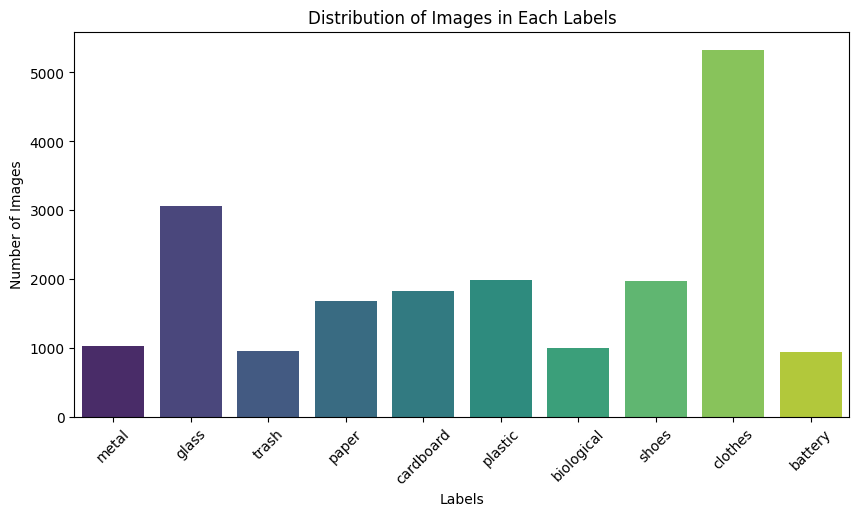

---------------Labels Distribution---------------
0        metal : 1020
1        glass : 3061
2         trash : 947
3        paper : 1680
4    cardboard : 1825
5      plastic : 1984
6    biological : 997
7        shoes : 1977
8      clothes : 5327
9       battery : 944
dtype: object


In [6]:
data = []
for subdir in os.listdir(path_data):
  subdir_path = os.path.join(path_data, subdir)
  if os.path.isdir(subdir_path):
    num_images = len(os.listdir(subdir_path))
    data.append((subdir, num_images))

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['Labels', 'Number of Images'])

# Plot the distribution of images
plt.figure(figsize=(10, 5))
sns.barplot(x='Labels', y='Number of Images', data=df, palette='viridis')
plt.title('Distribution of Images in Each Labels')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

print("---------------Labels Distribution---------------")
print(df['Labels'] + " : " + df['Number of Images'].astype(str))

In [7]:
# Function to check sample of images in a directory
def view_random_images_from_df(df, num_images=5):
    # Check label on df
    label_names = df['Labels'].unique()
    # Create a figure with subplots
    rows = len(label_names)
    cols = num_images
    width_size = cols * 2
    height_size = rows * 2
    fig, ax = plt.subplots(rows, cols, figsize=(width_size, height_size))

    # Loop through each label
    for i, label_name in enumerate(label_names):
        # Get the directory path for the label, join(main_dir, sub_dir)
        label_dir = os.path.join(path_data, label_name)

        # Get all image files in the directory
        image_files = os.listdir(label_dir)

        # Randomly sample image files in each sub directory based on num_images for the sample
        sampled_images = sample(image_files, num_images)

        # Loop through each sampled file
        for j, img_file in enumerate(sampled_images):
            img_path = os.path.join(label_dir, img_file)
            ax[i, j].set_title(f"{label_name}")
            ax[i, j].imshow(io.imread(img_path))
            ax[i, j].axis('off')

    plt.tight_layout()
    plt.show()

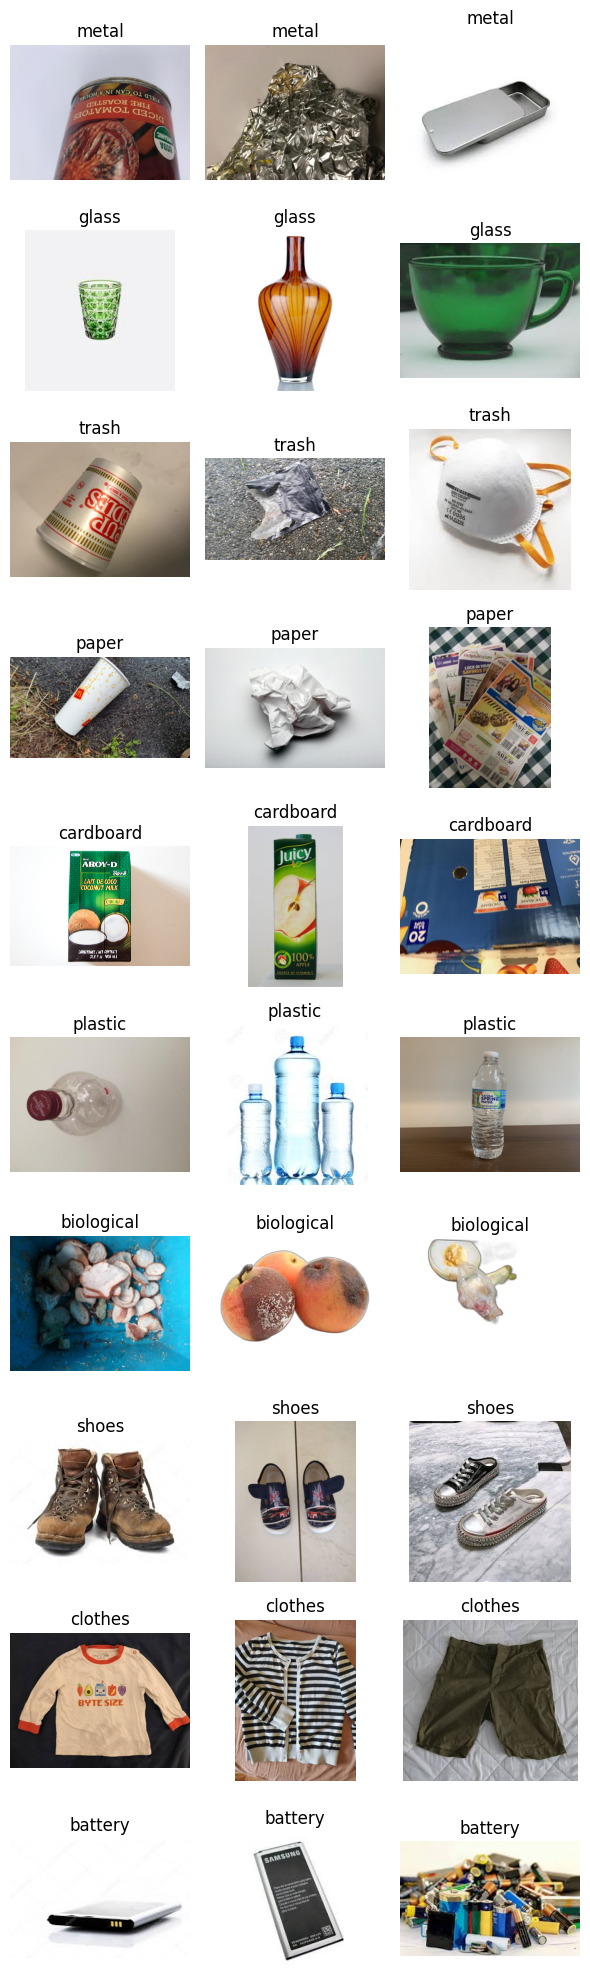

In [8]:
view_random_images_from_df(df, num_images=3)

### Data Preprocessing

In [9]:
# Create function for anti-clockwise rotation (melawan arah jarum jam)
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    corner = random.randint(0,180)
    return rotate(img, corner)

# Create function for clockwise rotation (searah jarum jam)
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    corner = random.randint(0,180)
    return rotate(img, -corner)

# Create function to flip the image horizontally from left to right
def flip_left_right(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.fliplr(img)

# Create function to flip the image vertically from top to bottom
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Create function to add brightness to the image
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Create function to add blur to the image
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Create function to add shear to the image
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Create function to add warp shift to the image
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [10]:
transform = {
    'anticlockwise_rotation': anticlockwise_rotation,
    'clockwise_rotation': clockwise_rotation,
    'flip_up_down': flip_up_down,
    'add_brightness': add_brightness,
    'blur_image': blur_image,
    'sheared': sheared,
    'warp_shift': warp_shift
}

# Find the max label size
max_label_size = df['Number of Images'].max()

# Generate augmented images for each target label to balance the dataset
for target_label in df['Labels']:
  # Check if target label is maximum
  if df[df['Labels'] == target_label]['Number of Images'].values[0] >= max_label_size:
    continue

  # Check if the label is already augmented
  if target_label.endswith('_augmented'):
    continue

  # Make path to save image augmented later
  augmented_path = os.path.join(path_data, f"{target_label}_augmented")
  if not os.path.exists(augmented_path):
    os.makedirs(augmented_path)

  label_dir = os.path.join(path_data, target_label)
  # Get the images files from sub directory (label or label such as trash)
  image_files = os.listdir(label_dir)
  # Make an array to save path of each image_files from sub_directory
  images = [os.path.join(label_dir, img_file) for img_file in image_files]

  current_size = len(image_files)
  generated_images = max_label_size - current_size
  num_generated = 1

  while num_generated <= generated_images:
    # Randomly select an image from the images list
    image = random.choice(images)

    if os.path.isfile(image):
      try:
        # Read the image
        original_image = io.imread(image)
        transform_image = None
        n = 0
        transformation_count = random.randint(1, len(transform))

        # Randomly select a transformation function
        while n < transformation_count:
          # Choice randomly the transform key from transform list
          transform_name = random.choice(list(transform.keys()))
          transform_image = transform[transform_name](original_image)
          n += 1

          new_image_path = os.path.join(augmented_path, f"augmented_image_{num_generated}.jpg")
          transformed_image = img_as_ubyte(transform_image)
          cv2.imwrite(new_image_path, transformed_image)
          print(f"Augmented image {num_generated} saved at {new_image_path}")

          num_generated += 1

      except ValueError as e:
        print('Could not read the', image, ':', e, 'hence skipping it.')

    else:
      print(f"Skipping {image} as it is not a file.")

Streaming output truncated to the last 5000 lines.
Augmented image 2735 saved at /content/dataset/garbage-dataset/shoes_augmented/augmented_image_2735.jpg
Augmented image 2736 saved at /content/dataset/garbage-dataset/shoes_augmented/augmented_image_2736.jpg
Augmented image 2737 saved at /content/dataset/garbage-dataset/shoes_augmented/augmented_image_2737.jpg
Augmented image 2738 saved at /content/dataset/garbage-dataset/shoes_augmented/augmented_image_2738.jpg
Augmented image 2739 saved at /content/dataset/garbage-dataset/shoes_augmented/augmented_image_2739.jpg
Augmented image 2740 saved at /content/dataset/garbage-dataset/shoes_augmented/augmented_image_2740.jpg
Augmented image 2741 saved at /content/dataset/garbage-dataset/shoes_augmented/augmented_image_2741.jpg
Augmented image 2742 saved at /content/dataset/garbage-dataset/shoes_augmented/augmented_image_2742.jpg
Augmented image 2743 saved at /content/dataset/garbage-dataset/shoes_augmented/augmented_image_2743.jpg
Augmented ima

Text(0.5, 1.0, 'Distribution of Images in Each Label After Augmentation')

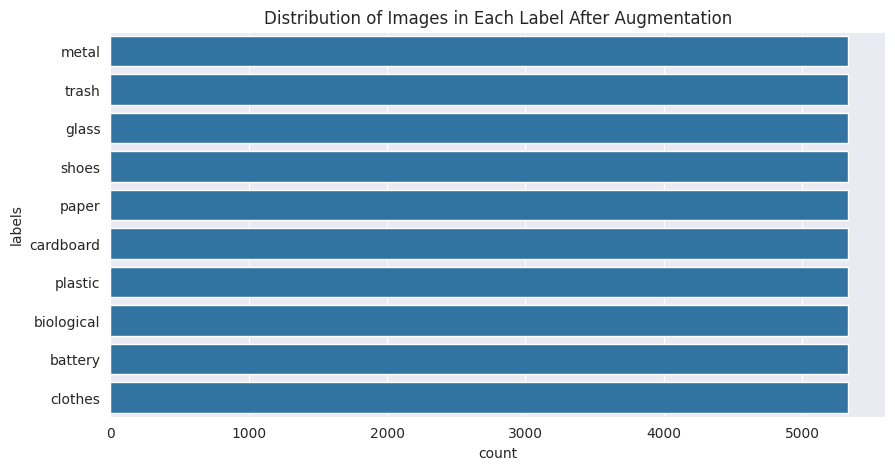

In [11]:
# Create list for each name files, path file, and labels on source path
# source path is path_data variable
file_name = []
labels = []
full_path = []

# Get all the name files, path file, and labels and save it to dataframe
for path, subdirs, files in os.walk(path_data):
    for name in files:
        file_name.append(name)
        # Combine the original and augmented labels
        label = path.split('/')[-1]
        if label.endswith('_augmented'):
            label = label.replace('_augmented', '')
        labels.append(label)
        full_path.append(os.path.join(path, name))

distribution = pd.DataFrame({'file_name': file_name, 'labels': labels, 'full_path': full_path})

# Plot the distribution of images
Label = distribution['labels']
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)
plt.title('Distribution of Images in Each Label After Augmentation')

#### Split Dataset

In [12]:
# Create variable for split dataset, X = data path, y = labels
X = distribution['full_path']
y = distribution['labels']

# Split the dataset into training, testing, and validation sets 60% train, 20% test, 20% validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Create DataFrame for training, testing, and validation sets
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train,'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test,'set': 'test'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val,'set': 'validation'})

# Concatenate the three DataFrames
df_all = pd.concat([df_tr, df_te, df_val], axis=0)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')


set         labels    
test        battery       1053
            biological    1098
            cardboard     1041
            clothes       1077
            glass         1054
            metal         1070
            paper         1034
            plastic       1075
            shoes         1060
            trash         1095
train       battery       3253
            biological    3204
            cardboard     3239
            clothes       3204
            glass         3209
            metal         3147
            paper         3153
            plastic       3198
            shoes         3224
            trash         3140
validation  battery       1021
            biological    1031
            cardboard     1049
            clothes       1046
            glass         1064
            metal         1110
            paper         1142
            plastic       1056
            shoes         1044
            trash         1095
dtype: int64 




In [13]:
# Check data
df_all.head(5)

,path,labels,set
37891,/content/dataset/garbage-dataset/shoes/shoes_1...,shoes,train
7922,/content/dataset/garbage-dataset/metal_augment...,metal,train
35284,/content/dataset/garbage-dataset/plastic_augme...,plastic,train
47867,/content/dataset/garbage-dataset/clothes/cloth...,clothes,train
45426,/content/dataset/garbage-dataset/battery_augme...,battery,train


In [14]:
# Create a directory final_dataset path
final_path = 'dataset/final_dataset'
if not os.path.exists(final_path):
    os.makedirs(final_path, exist_ok=True)

# Move the dataset to the final_dataset path
for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if not os.path.exists(file_path):
        continue

    set_path = os.path.join(final_path, row['set'])
    label_path = os.path.join(set_path, row['labels'])

    if not os.path.exists(label_path):
        os.makedirs(label_path, exist_ok=True)

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(final_path, row['set'], row['labels'], destination_file_name)

    # Check if the file already exists in the destination directory
    if not os.path.exists(file_dest):
        # Copy the file to the destination directory
        shutil.copy(file_path, file_dest)

0it [00:00, ?it/s]

In [15]:
# Define the path to the training, testing, and validation directories
train_dir = os.path.join(final_path, 'train')
test_dir = os.path.join(final_path, 'test')
val_dir = os.path.join(final_path, 'validation')

# Create object ImageDataGenerator for normalization and augmentation
target = (150, 150)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    fill_mode='nearest',
)

test_datagen = ImageDataGenerator(rescale=1/255.)  # Only normalize test data

# Create generator for training set
train_generator = datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=target,
    class_mode='categorical',
    shuffle=True,
)

# Create generator for validation set
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    batch_size=batch_size,
    target_size=target,
    class_mode='categorical',
    shuffle=False,
)

# Create generator for testing set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=batch_size,
    target_size=target,
    class_mode='categorical',
    shuffle=False,
)

Found 31971 images belonging to 10 classes.
Found 10658 images belonging to 10 classes.
Found 10657 images belonging to 10 classes.


## Modelling

In [16]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
for layer in base_model.layers:
    layer.trainable = False

In [18]:
model = Sequential()

model.add(base_model)
# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(128, (4, 4),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(128, (7, 7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((1, 1)))

# Flatten layer
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(128, activation = 'relu'))
# 1st Dropout Layer
model.add(Dropout(0.5))
# 2nd Dense Layer
model.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model.add(Dropout(0.3))

model.add(Dense(10, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model.compile(optimizer=tf.keras.optimizers.Adam(),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

# Summary of the Model Architecture
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 128)      │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1, 1, 128)      │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,313,074 (92.75 MB)

 Trainable params: 3,450,826 (13.16 MB)

 Non-trainable params: 20,862,248 (79.58 MB)

None


In [19]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0001, restore_best_weights=True, mode='max', baseline=0.95)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

callbacks = [checkpoint, lr_scheduler, early_stopping]

In [20]:
# Init epochs
epochs = 30

# Fit the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 279s 259ms/step - accuracy: 0.6086 - loss: 1.2355 - val_accuracy: 0.8309 - val_loss: 0.5388 - learning_rate: 0.0010
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 261s 261ms/step - accuracy: 0.8188 - loss: 0.6263 - val_accuracy: 0.8476 - val_loss: 0.4868 - learning_rate: 0.0010
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 244s 244ms/step - accuracy: 0.8436 - loss: 0.5434 - val_accuracy: 0.8539 - val_loss: 0.4670 - learning_rate: 0.0010
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 260s 242ms/step - accuracy: 0.8695 - loss: 0.4500 - val_accuracy: 0.8708 - val_loss: 0.4208 - learning_rate: 0.0010
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 244s 244ms/step - accuracy: 0.8807 - loss: 0.4081 - val_accuracy: 0.8729 - val_loss: 0.4084 - learning_rate: 0.0010
Epoch 6/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 251s 251ms/step - accuracy: 0.8976 - loss: 0.3567 - val_accuracy: 0.8883 - val_loss: 0.3714 - learning_rate: 0.0010
Epoch 7/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 248s 248ms

## Evaluasi dan Visualisasi

In [22]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

# Print the testing accuracy
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

  1/334 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.9688 - loss: 0.2066

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


334/334 ━━━━━━━━━━━━━━━━━━━━ 25s 74ms/step - accuracy: 0.9309 - loss: 0.2431
Testing Accuracy: 90.53%


In [23]:
# Create plot for accuracy and plot for loss
def plot_training_history(model):
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()


    plt.tight_layout()
    plt.show()

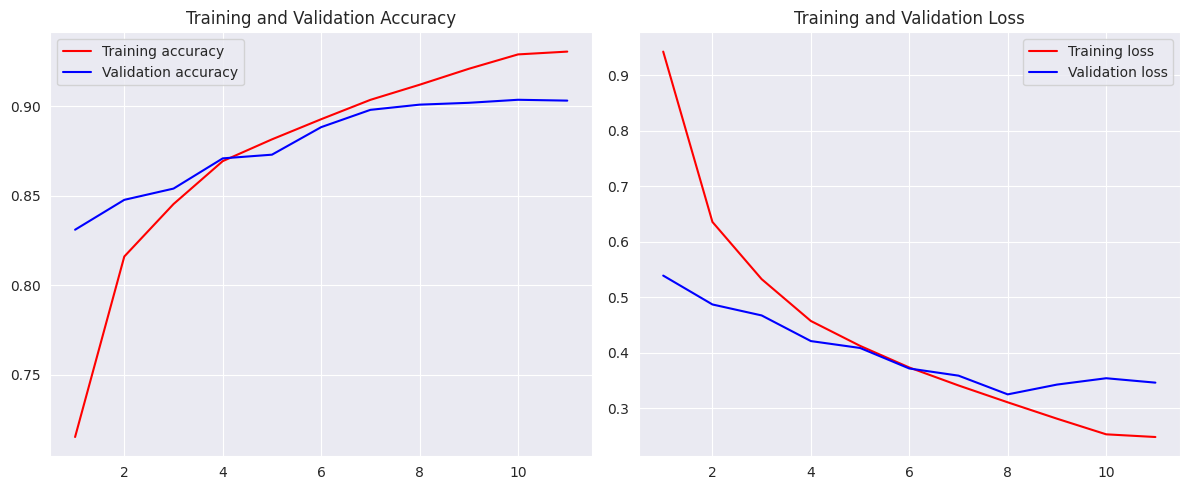

In [24]:
plot_training_history(history)

## Konversi Model

#### HDF5 Model Format

In [31]:
# HDF5 Model Format
model.save("model_HDF5_format.h5")

#### Saved Model Format

In [27]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

#### TFJS Model Fomat

In [33]:
# Install tensorflowjs
!pip install tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model_HDF5_format.h5 tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-23 08:34:09.479830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745397249.499210   17972 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

#### TFLite Model Format

In [34]:
# Convert the model to TensorFlow Lite format
converter_tf_lite = tf.lite.TFLiteConverter.from_keras_model(model)

# TFLite Model Conversion
tflite_model = converter_tf_lite.convert()

# Make directory for tflite model
if not os.path.exists('tflite_model'):
    os.makedirs('tflite_model')

# Save the TFLite model to a file
with open('tflite_model/model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpv_skgfgd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_132')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133093272636112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093268491920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093268492496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093272640720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093272637072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093272636688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093268494224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093268493648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093268491728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093268493072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133093271

## Inference (Optional)

In [38]:
# Create content for label file
label_file = 'tflite_model/labels.txt'
with open(label_file, 'w') as f:
    for label in train_generator.class_indices.keys():
        f.write(f"{label}\n")

In [39]:
# Load the model using tflite_model
interpreter = tf.lite.Interpreter(model_path='tflite_model/model.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load the labels
with open(label_file, 'r') as f:
    labels = [line.strip() for line in f.readlines()]

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype(np.float32) / 255.0
    return img_array

# Function to make predictions using the TFLite model
def predict_image_tflite(image_path):
    img_array = load_and_preprocess_image(image_path)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], img_array)

    # Run the inference
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get the predicted class
    predicted_class = labels[np.argmax(output_data)]

    return predicted_class, output_data

# Test the model with a sample image
test_image_path = '/content/dataset/garbage-dataset/battery/battery_1.jpg'

predicted_class, predictions = predict_image_tflite(test_image_path)

# Print the predicted class and probabilities
print(f"Predicted class: {predicted_class}")
print("Predicted probabilities:")
for label, prob in zip(labels, predictions[0]):
    print(f"{label}: {prob:.4f}")

Predicted class: battery
Predicted probabilities:
battery: 0.9950
biological: 0.0000
cardboard: 0.0027
clothes: 0.0000
glass: 0.0002
metal: 0.0001
paper: 0.0013
plastic: 0.0001
shoes: 0.0000
trash: 0.0006
